# LSST Kinematic Dipole Analysis

This notebook simulates and analyzes the kinematic dipole from LSST-like data, including:
- Realistic galaxy catalog generation
- Kinematic dipole injection
- Milky Way extinction with spatially varying R_V
- LSST selection function
- Tomographic dipole fitting
- Visualization

In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from iminuit import Minuit
from iminuit.cost import LeastSquares

from Simulation.simulMap import *

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# --- Step 1: Generate Mock Galaxy Catalog ---
def generate_galaxies(N, z_min=0.01, z_max=2.0, alpha=-1.2, m_star=-21.0, phi_star=0.01):
    z = np.random.uniform(z_min, z_max, N) # Redshift distribution: dN/dz ~ z^2 exp(-(z/z0)^1.5)
    L = 10**(0.4 * (m_star - np.random.exponential(1/phi_star, N))) # Luminosity function: Schechter
    # Apparent magnitude (simplified)
    m = m_star + 5 * np.log10(L) - 5 * np.log10(1e5) + 25  # Placeholder
    # RA/Dec: isotropic
    ra = np.random.uniform(0, 360, N)
    dec = np.random.uniform(-1, 1, N) #for dec, needs to use sin(dec), between -1 et 1
    dec = np.degrees(np.arcsin(dec))
    return ra, dec, z, m

## Alternative veresion proposed by Gemini:

In [ ]:
def generate_galaxies_corrected(N, z_min=0.01, z_max=0.5):
    # 1. Distribution du Redshift (simplifiée : uniforme en volume)
    z = np.random.uniform(z_min, z_max, N)
    
    # 2. Calcul de la distance de luminosité (Approximation pour z faible)
    # d = (c * z) / H0. On utilise d en Megaparsecs (Mpc)
    # H0 environ 70 km/s/Mpc, c environ 300 000 km/s
    d_L = (300000 * z) / 70 
    
    # 3. Magnitude Absolue (M) via une distribution de Schechter simplifiée
    # On génère des magnitudes typiques entre -18 (naines) et -22 (géantes)
    M_star = -20.5
    M = np.random.normal(M_star, 1.5, N) 
    
    # 4. Magnitude Apparente (m) : La formule du module de distance
    # m = M + 5 * log10(d_L) + 25  (quand d_L est en Mpc)
    m = M + 5 * np.log10(d_L) + 25
    
    # 5. Coordonnées RA/Dec (Isotrope)
    ra = np.random.uniform(0, 360, N)
    dec = np.random.uniform(-1, 1, N)
    dec = np.degrees(np.arcsin(dec))
    
    return ra, dec, z, m, M

In [ ]:
def schechter_mag(M, M_star, alpha):
    """Calcule la probabilité relative d'une magnitude M"""
    # Conversion magnitude -> luminosité relative L/L*
    L_ratio = 10**(0.4 * (M_star - M))
    return (L_ratio**alpha) * np.exp(-L_ratio)

def generate_schechter_magnitudes(N, M_min=-23, M_max=-15, M_star=-20.44, alpha=-1.1):
    magnitudes = []
    while len(magnitudes) < N:
        # 1. On tire une magnitude au hasard uniformément
        M_test = np.random.uniform(M_min, M_max)
        # 2. On tire une probabilité pour le test de rejet
        p_test = np.random.uniform(0, 1)
        
        # 3. Si p_test < probabilité de Schechter, on garde la magnitude
        if p_test < schechter_mag(M_test, M_star, alpha):
            magnitudes.append(M_test)
            
    return np.array(magnitudes)

In [ ]:
import numpy as np
from scipy.integrate import quad

def generate_full_galaxy_data(N, z_min=0.01, z_max=1.0):
    # --- 1. Paramètres Cosmologiques (Planck 2018) ---
    H0 = 67.4
    Om = 0.315
    Ol = 0.685
    c = 299792.458 # km/s
    L_sun = 3.828e26 # Watts
    M_sun_abs = 4.83 # Magnitude absolue du Soleil

    # --- 2. Génération des Redshifts (z) ---
    z = np.random.uniform(z_min, z_max, N)

    # --- 3. Calcul des Distances de Luminosité (dL) ---
    def get_dL(zi):
        inv_Ez = lambda zp: 1.0 / np.sqrt(Om * (1 + zp)**3 + Ol)
        integral, _ = quad(inv_Ez, 0, zi)
        return (c / H0) * (1 + zi) * integral

    dL_mpc = np.array([get_dL(zi) for zi in z])

    # --- 4. Génération des Magnitudes Absolues (M) via Schechter ---
    # M_star = coude, alpha = pente des naines
    M_star, alpha = -20.44, -1.1
    M_absolue = []
    while len(M_absolue) < N:
        M_test = np.random.uniform(-24, -14)
        L_ratio = 10**(0.4 * (M_star - M_test))
        prob = (L_ratio**alpha) * np.exp(-L_ratio)
        if np.random.uniform(0, 1) < prob:
            M_absolue.append(M_test)
    M_absolue = np.array(M_absolue)

    # --- 5. CALCULS DES LUMINOSITÉS ---
    # En unités de Luminosité Solaire (L_sun)
    L_solar_units = 10**(0.4 * (M_sun_abs - M_absolue))
    
    # En Watts
    L_watts = L_solar_units * L_sun

    # --- 6. CALCUL DE LA MAGNITUDE APPARENTE (m) ---
    m_apparente = M_absolue + 5 * np.log10(dL_mpc) + 25

    return {
        "redshift": z,
        "dist_Mpc": dL_mpc,
        "M_abs": M_absolue,
        "m_app": m_apparente,
        "L_solar": L_solar_units,
        "L_watts": L_watts
    }

# Exemple d'exécution
data = generate_full_galaxy_data(5)
print(f"Luminosité (Watts) de la 1ère galaxie : {data['L_watts'][0]:.2e} W")

## Test of chatGPT-generated ```generate_galaxies```:

Number of pixels = 49152


/tmp/ipykernel_17280/174182264.py:6: RuntimeWarning: divide by zero encountered in log10
  m = m_star + 5 * np.log10(L) - 5 * np.log10(1e5) + 25  # Placeholder


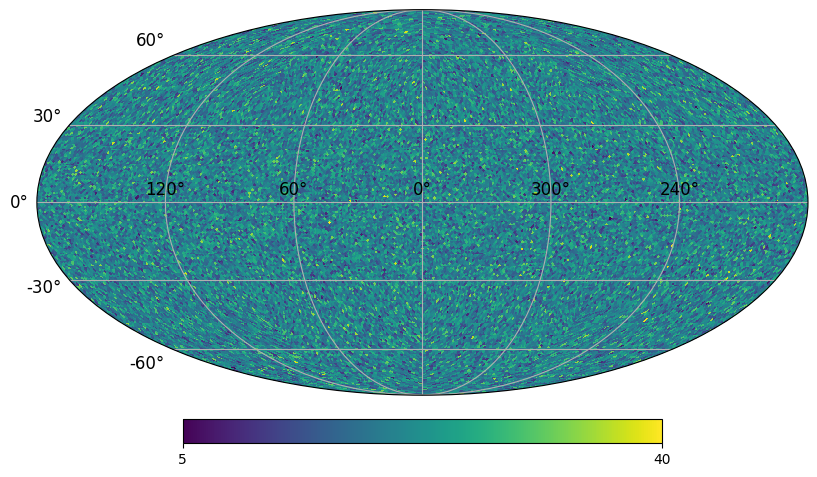

In [8]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print("Number of pixels = {}".format(NPIX))
NSources = int(1e6)

ra, dec, z, m = generate_galaxies(NSources)
Nsources_px = RADEC2NSource(NSIDE, ra, dec)
hp.projview(Nsources_px, graticule=True, graticule_labels=True);

In [ ]:
# --- Step 2: Apply Kinematic Dipole ---
def apply_dipole(ra, dec, z, v=370*u.km/u.s, dipole_dir=(264*u.deg, 48*u.deg)):
    c = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=1*u.Gpc, frame='icrs')
    x, y, z_coords = c.cartesian.x.value, c.cartesian.y.value, c.cartesian.z.value
    dipole = SkyCoord(ra=dipole_dir[0], dec=dipole_dir[1], frame='icrs')
    dx, dy, dz = dipole.cartesian.x.value, dipole.cartesian.y.value, dipole.cartesian.z.value
    beta = v/c.to(u.km/u.s).value
    gamma = 1/np.sqrt(1-beta**2)
    x_new = x + beta*(dx - (x*dx + y*dy + z_coords*dz)*x)
    y_new = y + beta*(dy - (x*dx + y*dy + z_coords*dz)*y)
    z_new = z_coords + beta*(dz - (x*dx + y*dy + z_coords*dz)*z_coords)
    new_c = SkyCoord(x=x_new*u.dimensionless_unscaled, y=y_new*u.dimensionless_unscaled, \
                      z=z_new*u.dimensionless_unscaled, representation_type='cartesian')
    return new_c.ra.deg, new_c.dec.deg

In [ ]:
# --- Step 3: Apply Milky Way Extinction with Spatially Varying R_V ---
def apply_extinction(ra, dec, m, ebv_map=None, rv_map=None):
    # Placeholder: Simulate E(B-V) and R_V maps
    if ebv_map is None:
        ebv = np.random.normal(0.03, 0.01, len(ra))
    if rv_map is None:
        rv = np.random.normal(3.1, 0.3, len(ra))
    A_r = rv * ebv * 2.753
    m_corrected = m + A_r
    return m_corrected

In [ ]:
# --- Step 4: Apply LSST Selection Function ---
def apply_lsst_selection(ra, dec, m, z):
    in_footprint = (dec > -60) & (dec < 30)
    detected = m < 27.5
    return in_footprint & detected

In [ ]:
# --- Step 5: Tomographic Dipole Fitting ---
def fit_dipole_tomographic(ra, dec, z, weights, z_bins=[0.1, 0.5, 1.0, 2.0]):
    results = []
    for z_min, z_max in zip(z_bins[:-1], z_bins[1:]):
        in_bin = (z > z_min) & (z < z_max)
        nside = 32
        ipix = hp.ang2pix(nside, np.radians(90-dec[in_bin]), np.radians(ra[in_bin]), nest=True)
        counts = np.bincount(ipix, weights[in_bin], minlength=hp.nside2npix(nside))
        
        def model(pix, A, l, b):
            theta, phi = hp.pix2ang(nside, pix)
            dipole_dir = hp.ang2vec(np.radians(90-b), np.radians(l))
            costheta = np.dot(hp.pix2vec(nside, pix), dipole_dir)
            return 1 + A * costheta
        
        try:
            popt, pcov = curve_fit(model, np.arange(len(counts)), counts, p0=[0.001, 264, 48])
            results.append(popt)
        except:
            results.append([np.nan, np.nan, np.nan])
    return results

In [ ]:
# --- Step 6: Visualization ---
def plot_skymap(ra, dec, weights, title):
    nside = 64
    ipix = hp.ang2pix(nside, np.radians(90-dec), np.radians(ra), nest=True)
    m = np.zeros(hp.nside2npix(nside))
    np.add.at(m, ipix, weights)
    hp.mollview(m, title=title, nest=True, cmap='viridis')
    plt.savefig('skymap.png', dpi=200, bbox_inches='tight')
    plt.close()

def plot_dipole_fits(results, z_bins):
    plt.errorbar(0.5*(np.array(z_bins[:-1])+np.array(z_bins[1:])), [r[0] for r in results], \
                 yerr=[0.0005]*len(results), fmt='o')  # Placeholder error
    plt.xlabel('Redshift')
    plt.ylabel('Dipole Amplitude')
    plt.title('Tomographic Dipole Fit')
    plt.grid(True)
    plt.savefig('dipole_fit.png', dpi=200, bbox_inches='tight')
    plt.close()

In [ ]:
# --- Generate and Analyze Mock Data ---
N = 100000  # Number of galaxies
ra, dec, z, m = generate_galaxies(N)
ra_dipole, dec_dipole = apply_dipole(ra, dec, z)
m_corrected = apply_extinction(ra_dipole, dec_dipole, m)
selected = apply_lsst_selection(ra_dipole, dec_dipole, m_corrected, z)

# Fit dipole in tomographic bins
results = fit_dipole_tomographic(ra_dipole[selected], dec_dipole[selected], z[selected], np.ones_like(ra_dipole[selected]))

# Generate plots
plot_skymap(ra_dipole, dec_dipole, np.ones_like(ra_dipole), 'Mock Galaxy Sky Map (with Dipole)')
plot_dipole_fits(results, z_bins=[0.1, 0.5, 1.0, 2.0])

## Notes
- Replace placeholder extinction and R_V maps with real data (e.g., from Planck or GAIA).
- Adjust the LSST selection function as needed (e.g., using CatSim).
- For more details, see the LSST Science Book and the references therein.